# Phase 1: The Refinery (Data Cleaning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- NODE 1: INGESTION ---
# Load the raw material
# Note: Adjust the filename if yours is different
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("✅ Data Loaded Successfully")
except FileNotFoundError:
    print("❌ ERROR: File not found. Please check the filename.")

# --- NODE 2: REFINERY (Structural Scan) ---
print("\n--- DIMENSIONS (Rows, Columns) ---")
print(df.shape)

print("\n--- DATA TYPES & NULLS (The GIGO Check) ---")
# This tells us if 'TotalCharges' is a float or an object (the trap)
print(df.info())

print("\n--- VISUAL INSPECTION (First 5 Rows) ---")
print(df.head())

✅ Data Loaded Successfully

--- DIMENSIONS (Rows, Columns) ---
(7043, 21)

--- DATA TYPES & NULLS (The GIGO Check) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies  

In [2]:
# --- NODE 2: THE REFINERY (Cleaning Station) ---

# 1. Fix the "TotalCharges" Trap
# errors='coerce' turns text errors into NaN (Nulls)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Encode the Target (Churn)
# Yes -> 1, No -> 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Drop useless identifiers
# 'customerID' has high entropy but zero information gain (it's just a label)
df.drop(columns=['customerID'], inplace=True)

# --- VALIDATION (Did it work?) ---
print("--- New Data Types ---")
print(df[['TotalCharges', 'Churn']].dtypes)

print("\n--- Missing Values Check (The Fallout) ---")
# Now we will see the real nulls that were hiding as blank spaces
print(df.isnull().sum())

--- New Data Types ---
TotalCharges    float64
Churn             int64
dtype: object

--- Missing Values Check (The Fallout) ---
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


# Phase 2: The Lab (EDA & Feature Selection)

--- CHURN DISTRIBUTION (Class Balance) ---
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_16184\3658375391.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


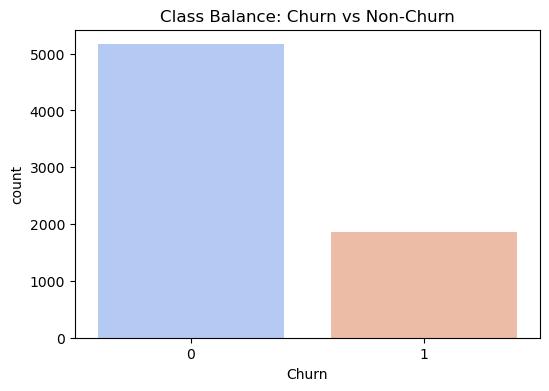

In [3]:
# --- NODE 2: REFINERY (Final Polish) ---
# Drop the 11 rows with missing TotalCharges
df.dropna(inplace=True)

# --- NODE 4: THE LAB (Univariate Analysis) ---
print("--- CHURN DISTRIBUTION (Class Balance) ---")
# normalize=True gives us the percentage, which is easier to read than raw counts
print(df['Churn'].value_counts(normalize=True))

# Visual Proof
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title('Class Balance: Churn vs Non-Churn')
plt.show()

--- CORRELATION WITH CHURN ---
Churn             1.000000
MonthlyCharges    0.192858
TotalCharges     -0.199484
tenure           -0.354049
Name: Churn, dtype: float64


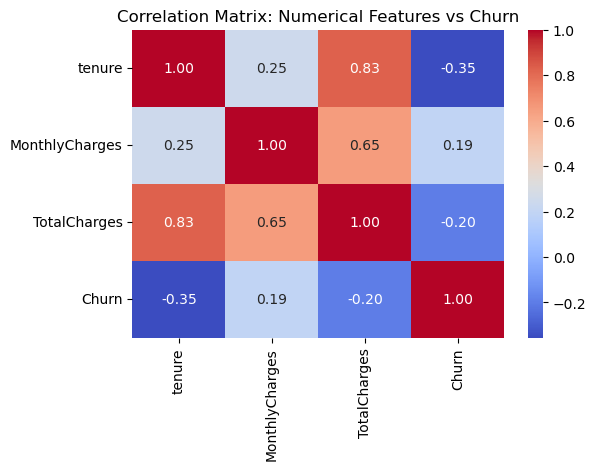

In [4]:
# --- NODE 4: THE LAB (Correlation Analysis) ---

# 1. Select only numerical columns for correlation
# We include 'Churn' to see how other numbers relate to it
cols_to_check = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
corr_matrix = df[cols_to_check].corr()

print("--- CORRELATION WITH CHURN ---")
# sorting values to see the strongest relationships at the top
print(corr_matrix['Churn'].sort_values(ascending=False))

# 2. Visual Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Numerical Features vs Churn')
plt.show()

--- TOP 5 DRIVERS OF CHURN (Information Gain) ---
Contract           0.104262
tenure             0.079738
TechSupport        0.068243
OnlineSecurity     0.061440
InternetService    0.059526
dtype: float64


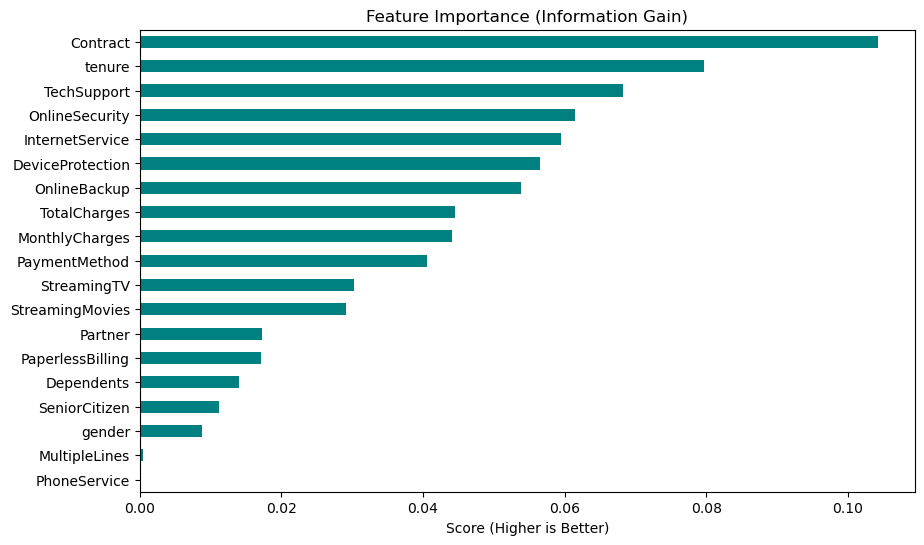

In [5]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# --- NODE 4: THE LAB (Information Gain Audit) ---

# 1. Prepare a temporary dataframe for math (don't mess up the original)
df_encoded = df.copy()

# 2. Encode all text columns into numbers (0, 1, 2...)
# The machine cannot read "Fiber Optic", it needs "1"
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

# 3. Separate Predictors (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 4. Calculate Information Gain (Mutual Information)
# discrete_features='auto' lets it handle the categorical codes
importances = mutual_info_classif(X, y, random_state=42)

# 5. Rank and Visualize
feat_importances = pd.Series(importances, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

print("--- TOP 5 DRIVERS OF CHURN (Information Gain) ---")
print(feat_importances.head(5))

# Plot
plt.figure(figsize=(10, 6))
feat_importances.plot(kind='barh', color='teal')
plt.title('Feature Importance (Information Gain)')
plt.xlabel('Score (Higher is Better)')
plt.gca().invert_yaxis() # Put the winner at the top
plt.show()

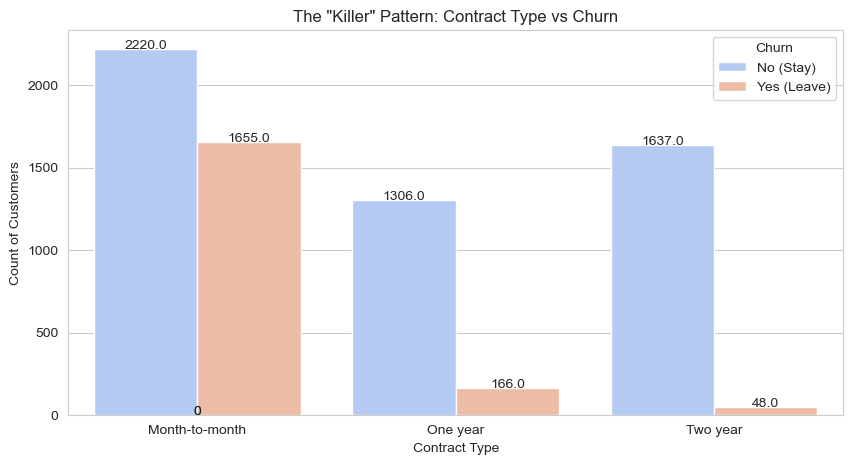

In [5]:
# --- NODE 4: THE LAB (Forensic Visualization) ---

# 1. Setting the aesthetic
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# 2. The "Hue" Trick
# We plot Contract on X, but we color-code by Churn (Target)
# This shows us the PROPORTION of churners in each bucket
sns.countplot(data=df, x='Contract', hue='Churn', palette='coolwarm')

plt.title('The "Killer" Pattern: Contract Type vs Churn')
plt.xlabel('Contract Type')
plt.ylabel('Count of Customers')
plt.legend(title='Churn', labels=['No (Stay)', 'Yes (Leave)'])

# 3. Add exact counts on top (for precision)
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline')

plt.show()

In [7]:
# --- NODE 6: THE DASHBOARD (Automated Audit) ---

# 1. Install the library (Run this only once)
# The '!' tells the notebook to run a terminal command
try:
    import ydata_profiling
    print("✅ Library already installed.")
except ImportError:
    print("⏳ Installing ydata-profiling... (This may take a minute)")
    !pip install ydata-profiling -q
    print("✅ Installation Complete.")

# 2. Import and Run
from ydata_profiling import ProfileReport

# 3. Generate the Report
# We use the 'df' (cleaned version)
profile = ProfileReport(df, title="Churn Data Architecture Report", explorative=True)

# 4. Display inside the notebook
# In Colab/Jupyter, this creates an interactive widget
profile.to_notebook_iframe()

✅ Library already installed.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|                                                                                           | 0/20 [00:00<?, ?it/s]
%|████████████████▌                                                                  | 4/20 [00:00<00:00, 28.50it/s]
%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  9.25it/s]
%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 11.91it/s]
%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:00,  8.70it/s]
%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  9.50it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.75it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Phase 3: The Engine (Model Training)

In [8]:
from sklearn.model_selection import train_test_split

# --- NODE 3: ADVANCED REFINERY (One-Hot Encoding) ---
# We use 'drop_first=True' to avoid redundancy (e.g., if it's not Male, it MUST be Female)
df_model = pd.get_dummies(df, drop_first=True)

# Define Features (X) and Target (y)
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# --- NODE 5: THE SPLIT (Holdout Method) ---
# We hold back 20% of data to test the robot later (The "Final Exam")
# random_state=42 ensures we get the same shuffle every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- DATA SHAPE AUDIT ---")
print(f"Original Shape:  {df.shape}")
print(f"Robot Inputs (X): {X_train.shape} (Note the extra columns from encoding)")
print(f"Training Size:   {X_train.shape[0]} customers")
print(f"Testing Size:    {X_test.shape[0]} customers")

--- DATA SHAPE AUDIT ---
Original Shape:  (7032, 20)
Robot Inputs (X): (5625, 30) (Note the extra columns from encoding)
Training Size:   5625 customers
Testing Size:    1407 customers


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# --- NODE 5: THE ENGINE (Model Training) ---

# 1. Initialize the Robot
# max_depth=5 means "Don't ask more than 5 questions to make a decision."
# This prevents the "Overfitting" trap.
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# 2. Train (The Learning Phase)
# The model looks at X_train (Data) and y_train (Answers)
model.fit(X_train, y_train)

# 3. Test (The Exam)
# We hide the answers (y_test) and ask the model to predict based on X_test
y_pred = model.predict(X_test)

# 4. Score Card
accuracy = accuracy_score(y_test, y_pred)

print(f"--- ROBOT REPORT CARD ---")
print(f"Training Data Size: {len(X_train)} rows")
print(f"Test Data Size:     {len(X_test)} rows")
print(f"Model Accuracy:     {accuracy:.2%}")

--- ROBOT REPORT CARD ---
Training Data Size: 5625 rows
Test Data Size:     1407 rows
Model Accuracy:     76.76%


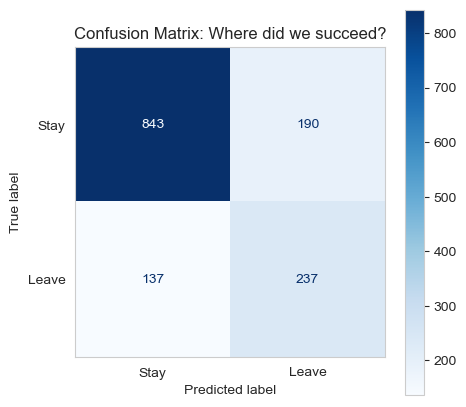


--- THE REAL SCORE ---
Total Churners in Test Set: 374
Churners We Caught (TP):    237
Churners We Missed (FN):    137
Recall (Capture Rate):      63.37%


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- NODE 7: THE AUDIT (Performance Evaluation) ---

# 1. Generate the Matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Visualize it
# Labels: 0 = Stay, 1 = Leave
# We use a standard plot function to draw the 2x2 grid
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stay', 'Leave'])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title('Confusion Matrix: Where did we succeed?')
plt.grid(False) # Clean look
plt.show()

# 3. Calculate "Recall" (The most important metric for Churn)
# Recall = True Positives / (True Positives + False Negatives)
# Definition: "Out of all the people who actually left, how many did we spot?"
tp = cm[1, 1] # Bottom Right Box (Caught Churners)
fn = cm[1, 0] # Bottom Left Box (Missed Churners)
recall = tp / (tp + fn)

print(f"\n--- THE REAL SCORE ---")
print(f"Total Churners in Test Set: {tp + fn}")
print(f"Churners We Caught (TP):    {tp}")
print(f"Churners We Missed (FN):    {fn}")
print(f"Recall (Capture Rate):      {recall:.2%}")

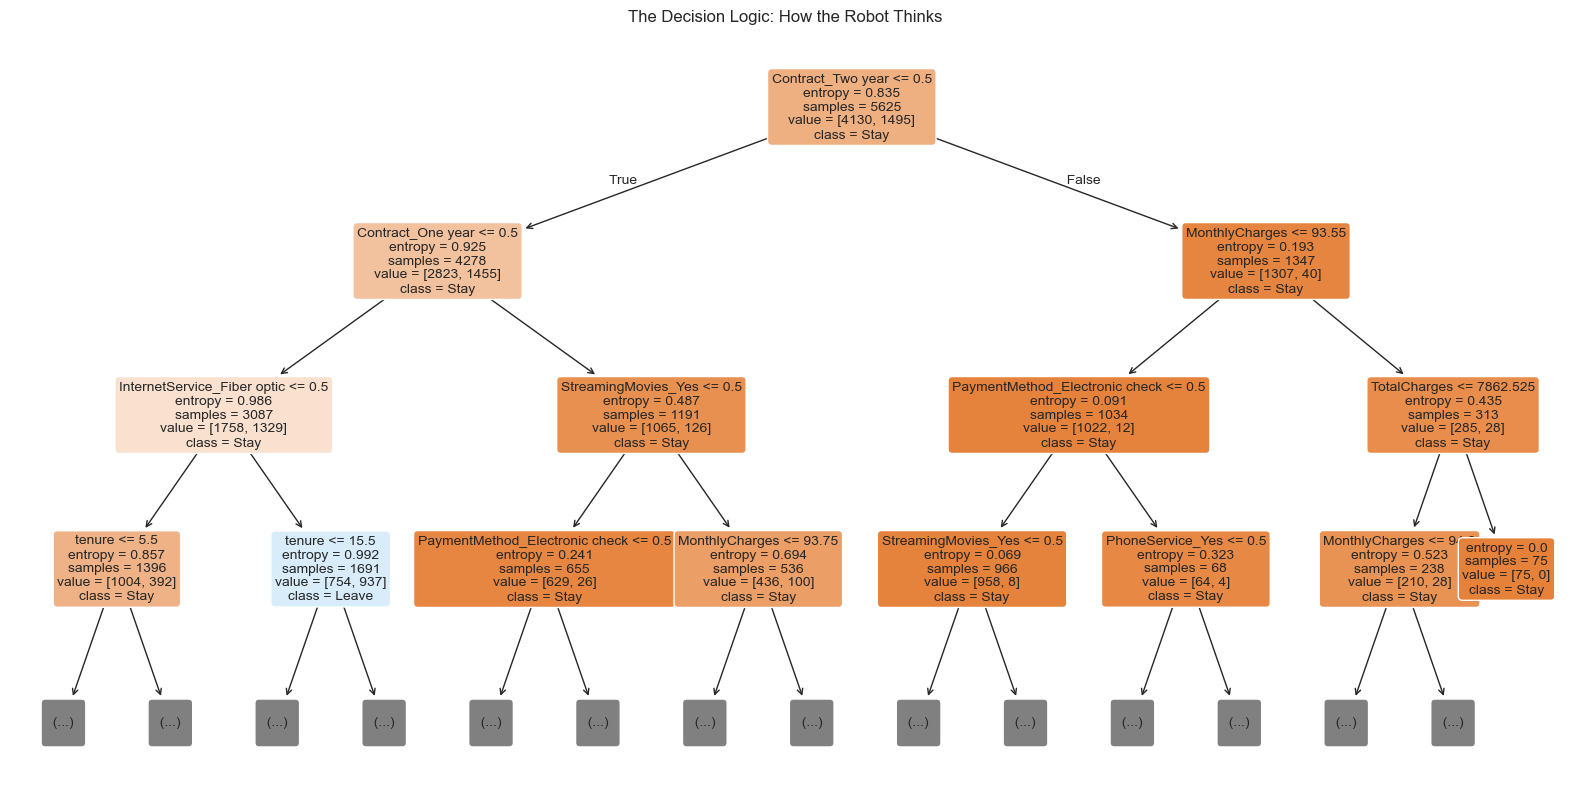

In [11]:
from sklearn.tree import plot_tree

# --- NODE 6: THE REPORT (White Box Visualization) ---

plt.figure(figsize=(20, 10))
plot_tree(model, 
          feature_names=X.columns,  
          class_names=['Stay', 'Leave'],
          filled=True,              # Color the boxes
          rounded=True,             # Nice corners
          fontsize=10, 
          max_depth=3)              # Only show top 3 levels for readability

plt.title("The Decision Logic: How the Robot Thinks")
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score

# --- NODE 5: THE ENGINE UPGRADE (Random Forest) ---

# 1. Initialize the Committee (The Forest)
# n_estimators=100: Create 100 trees.
# class_weight='balanced': KEY TRICK. This penalizes the model heavily
# if it misses a Churner. It forces the model to focus on "Yes Churn".
rf_model = RandomForestClassifier(n_estimators=100, 
                                  max_depth=8,       # Prevent overfitting
                                  random_state=42, 
                                  class_weight='balanced')

# 2. Train (The Committee meets)
rf_model.fit(X_train, y_train)

# 3. Predict (The Vote)
y_pred_rf = rf_model.predict(X_test)

# 4. The New Score Card
acc_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print("--- RANDOM FOREST VS SINGLE TREE ---")
print(f"Random Forest Accuracy: {acc_rf:.2%}")
print(f"Random Forest Recall:   {recall_rf:.2%}")
print("-" * 30)
print(f"Did we beat the old Recall (~63%)? {'YES' if recall_rf > 0.63 else 'NO'}")

--- RANDOM FOREST VS SINGLE TREE ---
Random Forest Accuracy: 74.77%
Random Forest Recall:   76.47%
------------------------------
Did we beat the old Recall (~63%)? YES


# Phase 4: The Audit (Financial Evaluation)

In [ ]:
# --- NODE 8: THE BOARDROOM (ROI Calculation) ---

def calculate_profit(y_actual, y_predicted, model_name):
    # 1. Get the Matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tp = cm[1, 1] # Caught Churners (The Prize)
    fp = cm[0, 1] # False Alarms (The Waste)

    # 2. Set Business Assumptions (The Variables)
    avg_ltv = 2000        # Average Lifetime Value of a customer ($)
    promo_cost = 50       # Cost of the incentive (discount/gift)
    success_rate = 0.20   # Only 20% of people accept the offer and stay

    # 3. The Money Math
    # Money Gained: We save 20% of the TP churners
    revenue_saved = tp * (avg_ltv * success_rate)

    # Money Lost: We pay the promo cost for EVERYONE we flagged (TP + FP)
    campaign_cost = (tp + fp) * promo_cost

    # Net Profit
    net_profit = revenue_saved - campaign_cost

    print(f"--- {model_name} FINANCIALS ---")
    print(f"Targeted Customers: {tp + fp} emails sent")
    print(f"Churners Saved:     {int(tp * success_rate)} customers")
    print(f"Revenue Saved:      ${revenue_saved:,.0f}")
    print(f"Campaign Cost:     -${campaign_cost:,.0f}")
    print(f"NET PROFIT:         ${net_profit:,.0f}")
    print("-" * 30)
    return net_profit

# Compare the two robots
# (Assuming y_pred is still the Single Tree and y_pred_rf is the Random Forest)
profit_tree = calculate_profit(y_test, y_pred, "Single Tree (63% Recall)")
profit_rf   = calculate_profit(y_test, y_pred_rf, "Random Forest (76% Recall)")

diff = profit_rf - profit_tree
print(f"💰 STRATEGIC VALUE: The Random Forest generates ${diff:,.0f} MORE profit.")